In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob
import math

#For NN
from keras.models import Sequential
from tensorflow import keras
from keras import backend as K
import tensorflow_addons as tfa
from keras.layers import Dense, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

## Import Data

In [266]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)

['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI', 'volatility_lag1', 'volatility_lag2', 'price_change_lag1', 'price_change_lag2', 'volume_change_lag1', 'volume_change_lag2', 'Crude_Oil_Index_Excess_Return_lag1', 'Crude_Oil_Index_Excess_Return_lag2', 'Ted_Rate_lag1', 'Ted_Rate_lag2', 'Gold_Price_lag1', 'Gold_Price_lag2', 'housing_lag1', 'housing_lag2', 'reserve_lag1', 'reserve_lag2', '10YGov_BondYield_lag1', '10YGov_BondYield_lag2', 'current_acct_lag1', 'current_acct_lag2', 'FX_Rate_lag1', 'FX_Rate_lag2', 'turnover_lag1', 'turnover_lag2', 'Population_lag1', 'Population_lag2', 'npl_lag1', 'npl_lag2', 'Recession_Indicators_lag1', 'Recession_Indicators_lag2', 'inflation_lag1', 'inflation_lag2', 'Unemployment_lag1', 'Unemployment_lag2', 'GDP_lag1', 'GDP_lag2']


In [361]:
# Selected by eliminating 30% 0f features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI',
 'current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1']

## Split data

In [362]:
train_index = math.ceil(len(quarters) * .7)
val_index = math.ceil(len(quarters) * .8)
train_quarters, val_quarters, test_quarters = quarters[:train_index], quarters[train_index:val_index], quarters[val_index:]
train = labeled_index.loc[train_quarters]
val = labeled_index.loc[val_quarters]
test = labeled_index.loc[test_quarters]
X_train = train[features_columns]
y_train = train['crash_label']
X_val = val[features_columns]
y_val = val['crash_label']
X_test = test[features_columns]
y_test = test['crash_label']

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(610, 36) (610,) (80, 36) (80,) (170, 36) (170,)


## Oversampling

In [363]:
# Oversample the minority class (1) using SMOTE
oversampler = SMOTE()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
print(X_train_resampled.shape, y_train_resampled.shape)

(1060, 36) (1060,)


In [364]:
crash_count = y_train_resampled.value_counts()[1]
crash_percen = crash_count / y_train_resampled.shape[0]
print("Oversampled crash percentage: ", crash_percen)

Oversampled crash percentage:  0.5


## Reshape

In [365]:
""" Changes data to the format for LSTM training 
for sliding window approach 
Goal: capture temporal dependencies in the data """
# Prepare the list for the transformed data

def lstm_transform(X_data, y_data, num_steps=5):
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(X_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= X_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = np.array(X_data)[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = np.array(y_data)[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_transformed = np.array(X)
    y_transformed = np.array(y)
    return x_transformed, y_transformed

In [366]:
X_train_reshaped, y_train_reshaped = lstm_transform(X_train_resampled, y_train_resampled)

X_val_reshaped, y_val_reshaped = lstm_transform(X_val, y_val)

X_test_reshaped, y_test_reshaped = lstm_transform(X_test, y_test)

In [367]:
print(X_train_reshaped.shape, y_train_reshaped.shape, X_val_reshaped.shape, y_val_reshaped.shape, X_test_reshaped.shape, y_test_reshaped.shape)

(1055, 5, 36) (1055,) (75, 5, 36) (75,) (165, 5, 36) (165,)


## Modelling

In [368]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

In [435]:
# Many-to-One Training
# X_train_reshaped[1]: number of time steps
# X_train_reshaped[2]: number of features

def create_model(optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer specified.')
        
    model = Sequential()
    model.add(LSTM(32, dropout=0.3, return_sequences=True, input_shape=(X_train_reshaped.shape[1],X_train_reshaped.shape[2])))  
    model.add(Dropout(0.3))
    model.add(LSTM(8, dropout=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)
    
    return model

In [416]:
# Hyperparam Tuning: optimizer, learning rate, batch size
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'adagrad', 'nadam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}
lstm_model = KerasClassifier(build_fn=create_model)
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=tscv)
grid_result = grid_search.fit(X_val_reshaped, y_val_reshaped)

# Get the best hyperparameters
best_learning_rate = grid_result.best_params_['learning_rate']
best_batch_size = grid_result.best_params_['batch_size']
best_optimizer = grid_result.best_params_['optimizer']

print("Best Optimizer:", best_optimizer)
print("Best Learning Rate:", best_learning_rate)
print("Best Batch Size:", best_batch_size)

In [436]:
model = create_model(best_optimizer, best_learning_rate)

model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 5, 32)             8832      
                                                                 
 dropout_57 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_105 (LSTM)             (None, 8)                 1312      
                                                                 
 dropout_58 (Dropout)        (None, 8)                 0         
                                                                 
 dense_65 (Dense)            (None, 1)                 9         
                                                                 
Total params: 10,153
Trainable params: 10,153
Non-trainable params: 0
_________________________________________________________________


In [437]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                classes=np.unique(y_train_reshaped), 
                y=y_train_reshaped)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

{0: 0.997164461247637, 1: 1.002851711026616}


In [438]:
train_class_weights = {0: 0.5, 1: 3}

In [439]:
model_result = model.fit(X_train_reshaped, y_train_reshaped, batch_size=best_batch_size, epochs=50, validation_data=(X_val_reshaped, y_val_reshaped),class_weight=train_class_weights)

Epoch 1/50


2024-04-07 15:13:45.361233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:13:45.892036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:13:46.323408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Cac

31/33 [===========================>..] - ETA: 0s - loss: 1.0292 - fn: 110.0000 - fp: 354.0000 - tn: 308.0000 - tp: 385.0000 - precision: 0.5210 - recall: 0.7778

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

33/33 [==============================] - ETA: 0s - loss: 1.0140 - fn: 110.0000 - fp: 378.0000 - tn: 314.0000 - tp: 418.0000 - precision: 0.5251 - recall: 0.7917

2024-04-07 15:13:54.722761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:13:54.886464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:13:55.253879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Cac

33/33 [==============================] - 13s 248ms/step - loss: 1.0140 - fn: 110.0000 - fp: 378.0000 - tn: 314.0000 - tp: 418.0000 - precision: 0.5251 - recall: 0.7917 - val_loss: 0.8410 - val_fn: 0.0000e+00 - val_fp: 64.0000 - val_tn: 1.0000 - val_tp: 10.0000 - val_precision: 0.1351 - val_recall: 1.0000
Epoch 2/50
33/33 [==============================] - 2s 48ms/step - loss: 0.6250 - fn: 6.0000 - fp: 417.0000 - tn: 112.0000 - tp: 520.0000 - precision: 0.5550 - recall: 0.9886 - val_loss: 1.0370 - val_fn: 0.0000e+00 - val_fp: 62.0000 - val_tn: 3.0000 - val_tp: 10.0000 - val_precision: 0.1389 - val_recall: 1.0000
Epoch 3/50
33/33 [==============================] - 1s 41ms/step - loss: 0.5289 - fn: 5.0000 - fp: 394.0000 - tn: 135.0000 - tp: 521.0000 - precision: 0.5694 - recall: 0.9905 - val_loss: 0.9950 - val_fn: 0.0000e+00 - val_fp: 57.0000 - val_tn: 8.0000 - val_tp: 10.0000 - val_precision: 0.1493 - val_recall: 1.0000
Epoch 4/50
33/33 [==============================] - 1s 40ms/step - l

33/33 [==============================] - 1s 29ms/step - loss: 0.2062 - fn: 12.0000 - fp: 95.0000 - tn: 434.0000 - tp: 514.0000 - precision: 0.8440 - recall: 0.9772 - val_loss: 0.5140 - val_fn: 4.0000 - val_fp: 14.0000 - val_tn: 51.0000 - val_tp: 6.0000 - val_precision: 0.3000 - val_recall: 0.6000
Epoch 28/50
33/33 [==============================] - 1s 30ms/step - loss: 0.2010 - fn: 13.0000 - fp: 83.0000 - tn: 446.0000 - tp: 513.0000 - precision: 0.8607 - recall: 0.9753 - val_loss: 0.5794 - val_fn: 3.0000 - val_fp: 18.0000 - val_tn: 47.0000 - val_tp: 7.0000 - val_precision: 0.2800 - val_recall: 0.7000
Epoch 29/50
33/33 [==============================] - 1s 32ms/step - loss: 0.1937 - fn: 13.0000 - fp: 84.0000 - tn: 445.0000 - tp: 513.0000 - precision: 0.8593 - recall: 0.9753 - val_loss: 0.7304 - val_fn: 3.0000 - val_fp: 27.0000 - val_tn: 38.0000 - val_tp: 7.0000 - val_precision: 0.2059 - val_recall: 0.7000
Epoch 30/50
33/33 [==============================] - 1s 32ms/step - loss: 0.2068 -

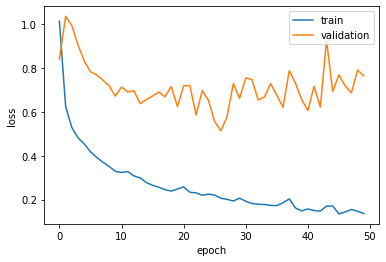

In [440]:
# Overfitting
plt.plot(model_result.history['loss'])
plt.plot(model_result.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [441]:
results = model.evaluate(X_test_reshaped, y_test_reshaped)
results

4/6 [===================>..........] - ETA: 0s - loss: 0.6152 - fn: 1.0000 - fp: 29.0000 - tn: 97.0000 - tp: 1.0000 - precision: 0.0333 - recall: 0.5000            

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x5x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x5x1x1xi1>'


6/6 [==============================] - 1s 139ms/step - loss: 0.5689 - fn: 1.0000 - fp: 35.0000 - tn: 128.0000 - tp: 1.0000 - precision: 0.0278 - recall: 0.5000


[0.5689142346382141, 1.0, 35.0, 128.0, 1.0, 0.02777777798473835, 0.5]

In [442]:
y_prob = model.predict(X_test_reshaped)
y_pred = np.where(y_prob > 0.5, 1, 0) # Adjust the threshold as needed
accuracy = accuracy_score(y_test_reshaped.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test_reshaped.flatten(), y_pred.flatten()))
mape = np.mean(np.abs((y_test_reshaped.flatten() - y_pred.flatten()) / y_test_reshaped.flatten())) * 100

conf_matrix = confusion_matrix(y_test_reshaped.flatten(), y_pred.flatten(), labels=[0, 1])

precision = precision_score(y_test_reshaped.flatten(), y_pred.flatten())
recall = recall_score(y_test_reshaped.flatten(), y_pred.flatten())
f1 = f1_score(y_test_reshaped.flatten(), y_pred.flatten())
fpr, tpr, thresholds = roc_curve(y_test_reshaped.flatten(), y_prob.flatten())
auc_roc = roc_auc_score(y_test_reshaped.flatten(), y_prob)

2024-04-07 15:14:51.308504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:14:51.371683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-07 15:14:51.657767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 59ms/step


## Evaluation

In [443]:
evaluation_result = {
    'Train_Start': pd.to_datetime(train_quarters).min(),
    'Train_End': pd.to_datetime(train_quarters).max(),
    'Val_Start': pd.to_datetime(val_quarters).min(),
    'Val_End': pd.to_datetime(val_quarters).max(),
    'Test_Start': pd.to_datetime(test_quarters).min(),
    'Test_End': pd.to_datetime(test_quarters).max(),
    'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
    'Precision': precision, 
    'Recall': recall, 
    'F1': f1, 
    'Accuracy': accuracy, 
    'RMSE': rmse,
    'MAPE': mape,
    'AUC-ROC': auc_roc,
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
    }
evaluation_result

{'Train_Start': Timestamp('1998-09-30 00:00:00'),
 'Train_End': Timestamp('2013-09-30 00:00:00'),
 'Val_Start': Timestamp('2013-12-31 00:00:00'),
 'Val_End': Timestamp('2015-09-30 00:00:00'),
 'Test_Start': Timestamp('2015-12-31 00:00:00'),
 'Test_End': Timestamp('2019-12-31 00:00:00'),
 'Confusion_Matrix': array([[128,  35],
        [  1,   1]]),
 'Precision': 0.027777777777777776,
 'Recall': 0.5,
 'F1': 0.05263157894736842,
 'Accuracy': 0.7818181818181819,
 'RMSE': 0.46709936649691375,
 'MAPE': nan,
 'AUC-ROC': 0.5306748466257669,
 'False Positive Rate': array([0.        , 0.00613497, 0.1595092 , 0.1595092 , 0.7791411 ,
        0.7791411 , 1.        ]),
 'True Positive Rate': array([0. , 0. , 0. , 0.5, 0.5, 1. , 1. ])}

In [444]:
evaluation = []
evaluation.append(evaluation_result)
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_features.csv", index=False)
evaluation_df

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,MAPE,AUC-ROC,False Positive Rate,True Positive Rate
0,1998-09-30,2013-09-30,2013-12-31,2015-09-30,2015-12-31,2019-12-31,"[[128, 35], [1, 1]]",0.027778,0.5,0.052632,0.781818,0.467099,NaN,0.530675,"[0.0, 0.006134969325153374, 0.1595092024539877...","[0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0]"
